In [1]:
# Import tools to work with matrices and graphs

import numpy as np
from graph import Graph
import operator

In [2]:
# Import tools for plotting plots

import matplotlib.pyplot as plt
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# Import tools from qiskit to execute the code on a quantum computer/simulator

from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

In [4]:
# Import tools for numerical optimization

from qiskit.aqua.components.optimizers import SPSA, SLSQP, COBYLA

In [5]:
def U_B(qc, beta):
    """ 
    A function to apply the RX gate with a rotation angle 2β to each qubit of the circuit
    
    Parameters: 
        qc (QuantumCircuit): The quantum circuit, to apply the RX gates on.
        beta (float): Half of the rotation angle.
    """
        
    for q in range(qc.n_qubits):
        qc.rx(2 * beta, q)

In [6]:
def U_C(qc, gamma, G):
    """ 
    A function to apply an RZ gate with a rotation angle γ, preceded and followed by CNOT gates,
    on each of the qubit pairs in the circuit that represent an edge in the given graph.
    
    Parameters: 
        qc (QuantumCircuit): The quantum circuit, to apply the RZ and CNOT gates on.
        gamma (float): The rotation angle.
        G (Graph): The graph, edges of which will be considered.
    """
    for edge in G.E:
        q1 = edge[0]
        q2 = edge[1]
        qc.cx(q1, q2)
        qc.rz(gamma, q2)
        qc.cx(q1, q2)

In [7]:
def expval(H, psi):
    """ 
    A function to compute the expected value of a Hermitian matrix associated with a given quantum state ψ.
    
    Parameters: 
        H (numpy.ndarray): The Hermitian matrix, the expected value of which has to be computed.
        psi (float list): The quantum state that the expected value of H should be associated with.
    
    Returns: 
        float: The expected value of H associated with the state ψ.
    """
    
    psi_dagger = np.conjugate(psi)
    return np.matmul(np.matmul(psi, H), psi_dagger)

In [8]:
def ampl_to_probs(c):
    """ 
    A function to compute the probability of a quantum state, given its amplitude/coefficient.
    
    Parameters: 
        c: A complex number representing an amplitude or coefficient of a quantum state.

    Returns: 
        float: A probability value (from [0, 1]), calculated as the sum of squares of real and imaginary
            parts of c.
    """

    return c.real * c.real + c.imag * c.imag

In [9]:
def to_binstring(k, n):
    """ 
    A function to compute the binary string of a given integer k
    
    Parameters: 
        k (int): The integer binary value of which will be computed.
        n (int): The number of digits in the binary form.
        
    Returns:
        str: A string representing the binary representation of k.
    """
    
    return ("{0:0" + str(n) + "b}").format(k)

In [10]:
def QAOA(G, gammas, betas, edge=None, qc=None, p=1, simulate=True, args=None):
    """ 
    A function that executes the Quantum Approximate Optimization Algorithm
        for a given graph G on an IBMQ device.
    
    Parameters: 
        * G (Graph): The graph that should be considered.
        * gammas (float list): A list of γ parameters of size p, used when RZ gates are applied on the edges of G.
        * betas (float list): A list of β parameters of size p, used when RX gates are applied on all qubits of qc.
        * edge (int tuple): A tuple that represents an edge in G of form (u, v), where u and v are vertices
            in the undirected graph G, or (u, v, w) in the weighted graph G, where w represents the weight
            of the edge. In optimization phase, used to calculate the expected value of the output.
        * qc (QuantumCircuit): the quantum circuit that QAOA will work on.
            If None, then qc is created with G.n quantum and n classical registers.
        * p (int): the number of layers, i.e., the number of β/γ parameters to apply.
        * simulate (bool): If False, the algorithm will run on an IBMQ real device; otherwise, on a simulator.
        
        * args (dict): Additional arguments:
            - backend (str): The name of the IBMQ backend to execute the algorithm on (using the main provider).
                recommended: 'ibmqx2' if n <= 5; 'ibmq_16_melbourne' if 5 < n <= 16.
            - shots (int): Number of shots, 4096 by default.
            - monitor (bool): Monitor the job, false by default.
        
    Returns:
        float (if edge is not None): The expected value of Z^2 associated with the resulting state of amplitudes.
    """
    
    if not simulate:
        assert 'backend' in args, 'specify a backend, or switch on the simulate flag'
        backend = args['backend']    
        monitor = args['monitor'] if 'monitor' in args else False  
    
    shots = args['shots'] if 'shots' in args else 4096
        
    n = G.n # number of vertices on the graph G (number of qubits in the circuit)
    if qc is None: # create a quantum circuit if none was passed
        qr = QuantumRegister(n)
        cr = ClassicalRegister(n)
        qc = QuantumCircuit(qr, cr)
        
    # check that the number of qubits in qc and the number of vertices in G are equal
    assert n == qc.n_qubits, 'the circuit\'s number of qubits ({}) \
                                is not equal to |V(G)|=({})'.format(qc.n_qubits, n)
    
    # check that the lists of β/γ parameters have length equal to the number of layers 
    assert len(betas) == p, 'the number of beta parameters |β|=({}) \
                                is not equal to the number of layers p=({})'.format(len(betas), p)
    assert len(gammas) == p, 'the number of gamma parameters |γ|=({}) \
                                is not equal to the number of layers p=({})'.format(len(gammas), p)
    
    
    # apply Hadamard gates to all qubits of qc so that they will be in uniform superposition 
    for q in range(n):
        qc.h(q)
    
    # for each layer, apply the U_C gates on all pairs of qubits representing the edges of G
    # and the U_B gates on all qubits of qc 
    
    for i in range(p):
        U_C(qc, gammas[i], G)
        U_B(qc, betas[i])
                
    # if no edge was provided (final stage), then measure and return
    if edge is None:
        return qc.measure(range(n), range(n))
    
    # otherwise, initialize the array, that will contain probabilities for each state
    output = [0] * 4
    
    # Z^2 is the Kronecker product of the Pauli Z matrix with itself
    Z = [[1, 0], [0, -1]]
    Z2 = np.kron(Z, Z)
    
    # indices of endpoints of edge 
    q1 = edge[0]
    q2 = edge[1]

    # and access the IBMQ provider, get the backend, run the job, and grab the results
    if simulate:
        backend = Aer.get_backend('statevector_simulator')
        job = execute(qc, backend)
        result = job.result()
        statevector = result.get_statevector(qc)

        # get the state probabilities from resulting amplitudes of current state
        state_probabilities = list(map(ampl_to_probs, statevector))
        
        # map the n possible states to their corresponding binary string representations
        bin_strings = [to_binstring(i, n) for i in range(len(state_probabilities))]

        # for each possible binstring, check the bits at indices that correspond to endpoints of edge
        # for each of the possible pairs, increment by the probability of obtaining the current binstring the:
        #    00 -> first coordinate of the output state (both vertices are selected in set A)
        #    01 -> second coordinate of the output state (vertex at q1 is selected in set A, and vertex at q2 in set B)
        #    10 -> third coordinate of the output state (vertex at q1 is selected in set B, and vertex at q2 in set A)
        #    11 -> forth coordinate of the output state (both vertices are selected in set B)
        
        for bin_string in bin_strings:
            index = int(bin_string[q1] + bin_string[q2], 2)
            output[index] += state_probabilities[int(bin_string, 2)]
        
    else:
        # measure the circuit
        qc.measure(range(n), range(n))

        provider = IBMQ.load_account()
        backend = provider.get_backend(backend)
        job_exp = execute(qc, backend=backend, shots=shots)
        
        if monitor:
            job_monitor(job_exp)
        exp_results = job_exp.result()
        counts = exp_results.get_counts()

        # for each result of the job, check the bits at indices that correspond to endpoints of edge
        # for each of the possible pairs, increment by one the:
        #    00 -> first coordinate of the output state (both vertices are selected in set A)
        #    01 -> second coordinate of the output state (vertex at q1 is selected in set A, and vertex at q2 in set B)
        #    10 -> third coordinate of the output state (vertex at q1 is selected in set B, and vertex at q2 in set A)
        #    11 -> forth coordinate of the output state (both vertices are selected in set B)
        
        # normalize the results (to get probabilities of each state) by dividing the final counts by the number of shots 
        
        for bin_string in counts.keys():
            index = int(bin_string[q1] + bin_string[q2], 2)
            output[index] += counts[bin_string] / shots
    
    # return the expected value of Z^2, associated to the output state
    return expval(Z2, output)

In [35]:
def maxcut(G, opt_args, p=1, simulate=True, args=None):
    """ 
    A function that solves the Max-Cut problem for a given graph G, using QAOA.
    
    Parameters: 
        * G (Graph): The graph that should be considered.
        * opt_args(dict): Arguments for the optimizer:
            - max_iter (int): The number of maximum iterations to use.
            - tolerance (float): The maximum tolerated error.
        * p (int): the number of layers, i.e., the number of β/γ parameters to apply.
        * simulate (bool): If False, QAOA will run on an IBMQ real device; otherwise, on a simulator.
        * args (dict): Additional arguments:
            - backend (str): The name of the IBMQ backend to execute the algorithm on (using the main provider).
                recommended: 'ibmqx2' if n <= 5; 'ibmq_16_melbourne' if 5 < n <= 16.
            - shots (int): Number of shots; 4096 by default.
            - monitor (bool): Monitor the job; false by default.
            - plot_most_freq_bits (bool): If True, will plot the distribution of the most frequently sampled
                bit strings; true by default.
    (TO-DO) - plot_circuit (bool): If True, will plot the quantum circuit in the final phase; true by default.
    Returns:
        * float: The minimum expected value of the cost function
        * dict: A dictionary, storing 2^G.n binary strings and their frequencies when sampled. 
        * string: The most frequently sampled bit.
    """
    
    # the objective function
    def objective(params):
        cost = 0
        
        # take first p params as γ, and the last p params as β
        # if p = 1, γ/β are scalars, not lists, so we need to convert them to lists (to iterate on them in QAOA)
        
        gammas = [params[0]] if p == 1 else params[:p]
        betas = [params[1]] if p == 1 else params[p:]
        for edge in G.E:
            expval = 1 - QAOA(G, gammas, betas, edge=edge, p=p, simulate=simulate, args=args)
            cost -= 0.5 * expval * (edge[2] if G.isWeighted else 1) # edge[2] = weight(edge)
        return cost
    
    # plotting the histogram of final counts
    def plot_hist(counts, color='lightpink'):
        # sorting the counts based on frequencies (values) of the bit strings (keys)
        sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1])}
        
        # filtering the most frequent bits (picking the first 30 if there are more than 30 bit strings)
        most_freq_bits = sorted_counts if len(sorted_counts) <= 30 else list(sorted_counts)[len(sorted_counts)-30:]

        plt.bar(most_freq_bits, [counts[bit] for bit in most_freq_bits], color=color)
        _, _ = plt.xticks(rotation=80)
        plt.show()
        
        
    assert simulate backend args
    # initial parameters - a list of size 2p, where the first p values are the γs and the last p values are βs
    initial_params = 0.01 * np.random.rand(2 * p)

    # unpacking the optimizer arguments and declare the optimizer
    max_iter = opt_args['max_iter'] if 'max_iter' in opt_args else (100 if simulate else 10)
    tol = opt_args['toleration'] if 'toleration' in opt_args else 0.0001 
    optimizer = COBYLA(maxiter=max_iter, tol=tol)
    
    # optimization phase
    minimizers, min_cost, _ = optimizer.optimize(num_vars=2*p, 
                                                    objective_function=objective,
                                                    initial_point=initial_params)
    
    # if p = 1, γ/β are scalars, not lists, so we need to convert them to lists (to iterate on them in QAOA)
    opt_gammas = [minimizers[0]] if p == 1 else minimizers[:p]
    opt_betas = [minimizers[1]] if p == 1 else minimizers[p:]
    print('Minimal expectation value: {}'.format(min_cost))
    print('Optimal parameters: \nγ = {}, \nβ = {}'.format(opt_gammas, opt_betas))
    
    # unpacking the arguments
    if not simulate:
        assert 'backend' in args, 'specify a backend, or switch on the simulate flag'
        backend = args['backend']
        monitor = args['monitor'] if 'monitor' in args else False
    
    shots = args['shots'] if 'shots' in args else 4096
    plot_most_freq_bits = args['plot_most_freq_bits'] if 'plot_most_freq_bits' in args else True
    plot_circuit = args['plot_circuit'] if 'plot_circuit' in args else True

    # final phase
    qr = QuantumRegister(G.n)
    cr = ClassicalRegister(G.n)
    qc = QuantumCircuit(qr, cr)
    QAOA(G, opt_gammas, opt_betas, qc=qc, p=p, simulate=simulate, args = args)
    
    # pick the backend, run the job, and grab the counts
    if simulate:
        backend_sim = Aer.get_backend('qasm_simulator')
        job_sim = execute(qc, backend_sim, shots=shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts()
    else:
        provider = IBMQ.load_account()
        backend = provider.get_backend(backend)
        job_exp = execute(qc, backend=backend, shots=shots)
        job_monitor(job_exp)
        exp_results = job_exp.result()
        counts = exp_results.get_counts()

    most_freq_bit = max(counts.items(), key=operator.itemgetter(1))[0]
    
    print('\nNumber of layers: {}.'.format(p))
    if plot_most_freq_bits:
        print('\nHistogram of the most frequent bits:')
        plot_hist(counts)

    print('\nMost frequently sampled bit string is: {}'.format(most_freq_bit))
    
    # pick the cut edges and classify the vertices of G correspondingly
    cut_edges = []
    for edge in G.E:
        if most_freq_bit[edge[0]] != most_freq_bit[edge[1]]:
            cut_edges.append(edge)
    g.draw(colors=['r' if bit == '0' else 'c' for bit in most_freq_bit], cut_edges=cut_edges)
    
    return min_cost, counts, most_freq_bit

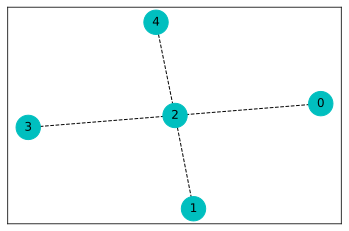

In [36]:
E = [(2, 0), (1, 2), (2, 3), (4, 2)]

g = Graph(5, E)
g.draw()

Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run
Minimal expectation value: -2.472002327442169
Optimal parameters: 
γ = [0.29657005 0.42493442], 
β = [1.07296288 1.08342054]


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run

Number of layers: 2.

Histogram of the most frequent bits:


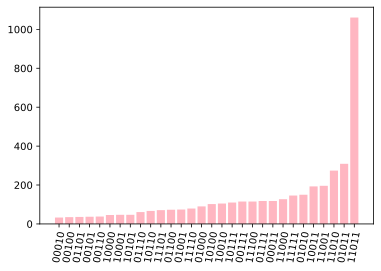


Most frequently sampled bit string is: 11011


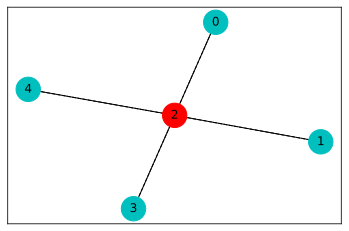

In [41]:
cost, counts, most_freq_bit = maxcut(g, opt_args={'max_iter': 20}, p=2, simulate=False,
                                     args={'backend': 'ibmqx2', 'monitor': True})

In [ ]:
# TO-DOs

# 1. Drawing the circuit
# 2. instead of maxiter try errors
# 3. try SPSA/SLSQP, if went well, add an option to choose the optimizer